# Импорт TensorFlow и других библиотек

In [ ]:
import tensorflow as tf # основная библиотека для работы с нейронными сетями
from tensorflow.keras.preprocessing.image import ImageDataGenerator # класс для генерации изображений с аугментацией (изменением) в реальном времени
from tensorflow.keras.applications import MobileNetV2 # предобученная модель для классификации изображений, которая использует архитектуру MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D # слои, которые будут добавлены к модели
from tensorflow.keras.models import Model # класс для создания модели
from tensorflow.keras.optimizers import Adam # оптимизатор, который будет использоваться для обучения модели
from tensorflow.keras.callbacks import EarlyStopping # коллбэк, который позволяет остановить обучение, если модель перестает улучшаться

# Опеределение нехоторых параметров для загрузчика:

In [ ]:
IMG_SIZE = (224, 224) # определение размера изображения
BATCH_SIZE = 32 # определение размера пакета (т.е. за один шаг 32 изображения)
EPOCHS = 15 # количество эпох (т.е. сколько раз мы проходим по всем изображениям при обучении модели)
NUM_CLASSES = 10 # количество классов (т.е. сколько различных типов изображений)
TRAIN_PATH = "path" # путь к папке с изображениями для обучения

# Создание генератора данных

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # нормализация изображений. Пиксели изображений обычно имеют значения от 0 до 255. Деление на 255 приводит значения пикселей к диапазону от 0 до 1, что помогает улучшить обучение модели
    validation_split=0.2, # 20% данных будут отложены для валидации
    rotation_range=20, # случайное поворот изображения на 20 градусов
    zoom_range=0.2, # случайное увеличение или уменьшение изображения на 20%
    horizontal_flip=True # изображения могут быть случайным образом перевернуты по горизонтали
)

#Генератор для обучения
# 'тот метод создает генератор, который будет загружать изображения из указанной директории. Директория должна быть организована по классам, где каждая поддиректория соответствует одному классу.
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, # путь к дереткории с изображениями
    target_size=IMG_SIZE, # размер изображения, которое будет загружено
    batch_size=BATCH_SIZE, # размер пакета, который будет использоваться при обучении
    class_mode='sparse', # метки классов будут возвращаться в виде целых чисел
    subset='training' # генератор будет использоваться для обучающей выборки
)
#Генератор для валидации
val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


 # Загрузка предобученной модели

In [ ]:
base_model = MobileNetV2(
    weights='imagenet', # указывает, что мы хотим загрузить веса, предобученные на наборе данных ImageNet. Это позволяет использовать уже обученные представления, что значительно ускоряет процесс обучения и улучшает качество модели
    include_top=False, # указывает, что мы не хотим включать верхний (выходной) слой модели. Это позволяет нам добавлять свои собственные слои для классификации, соответствующие нашей задаче
    input_shape=(224, 224, 3) # форма входных данных 224х224 RGB
)

base_model.trainable = False # замораживаем базовые слои (Замораживание базовых слоев позволяет избежать переобучения)

x = base_model.output # получаем выходные данные из базовой модели
x = GlobalAveragePooling2D()(x) # слой выполняет глобальное усреднение по пространственным размерам (ширине и высоте) выходных данных базовой модели
x = Dense(512, activation='relu')(x) # добавляем полносвязный (Dense) слой с 512 нейронами и активацией ReLU. Этот слой позволяет модели учиться на более сложных представлениях данных
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # добавляем выходной слой с количеством нейронов, равным количеству классов (NUM_CLASSES). Активация softmax используется для многоклассовой классификации, так как она преобразует выходные значения в вероятности, которые суммируются до 1

model = Model(inputs=base_model.input, outputs=predictions) # создаем объект модели, который принимает входные данные из базовой модели и возвращает предсказания из выходного слоя

# Компиляция модели

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), # оптимизатор Adam, который является одним из самых популярных оптимизаторов для обучения нейронных сетей. Скорость обучения (learning rate), которая определяет, насколько сильно обновляются веса модели на каждом шаге обучения
    loss='sparse_categorical_crossentropy', # функция потерь, которая используется для многоклассовой классификации, когда метки классов представлены в виде целых чисел
    metrics=['accuracy'] # точность (accuracy) модели во время обучения и валидации. Точность — это доля правильно классифицированных примеров от общего числа примеров
)

# Обучение модели

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', # указывает, что мы будем следить за значением функции потерь на валидационном наборе данных
    patience=3) # указывает количество эпох, в течение которых модель должна продолжать обучение

history = model.fit(
    train_generator, # генератор, который предоставляет данные для обучения
    validation_data=val_generator, # генератор, который предоставляет данные для валидации
    epochs=EPOCHS, # количество эпох, в течение которых модель будет обучаться
    callbacks=[early_stop] # список коллбэков, которые будут использоваться во время обучения
)

Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8097 - loss: 0.6578

C:\Users\Mamsheva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 562s 852ms/step - accuracy: 0.8099 - loss: 0.6574 - val_accuracy: 0.9314 - val_loss: 0.2070
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 508s 775ms/step - accuracy: 0.9384 - loss: 0.1990 - val_accuracy: 0.9392 - val_loss: 0.1923
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 512s 782ms/step - accuracy: 0.9458 - loss: 0.1716 - val_accuracy: 0.9400 - val_loss: 0.1953
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 498s 760ms/step - accuracy: 0.9477 - loss: 0.1589 - val_accuracy: 0.9413 - val_loss: 0.1803
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 508s 776ms/step - accuracy: 0.9538 - loss: 0.1442 - val_accuracy: 0.9450 - val_loss: 0.1685
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 506s 773ms/step - accuracy: 0.9569 - loss: 0.1294 - val_accuracy: 0.9436 - val_loss: 0.1807
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 503s 769ms/step - accuracy: 0.9618 - loss: 0.1232 - val_accuracy: 0.9495 - val_loss: 0.1652
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 520s 795ms/step - accuracy: 0.9631 - loss: 0.11

# Конвертация модели в формат TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) #  метод создает экземпляр TFLiteConverter, который позволяет конвертировать модель Keras в формат TensorFlow Lite
tflite_model = converter.convert() # конвертация модели в формат TFLite

# сохранение модели в файл
with open('animals10_1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Mamsheva\AppData\Local\Temp\tmp1e4tjjqg\assets


INFO:tensorflow:Assets written to: C:\Users\Mamsheva\AppData\Local\Temp\tmp1e4tjjqg\assets


Saved artifact at 'C:\Users\Mamsheva\AppData\Local\Temp\tmp1e4tjjqg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2080743849616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774079120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774079888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080743849424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774078928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774081040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774081424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774081616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080774079312: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [  1 224 224   3]
Output shape: [ 1 10]


C:\Users\Mamsheva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# Проверка работы модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


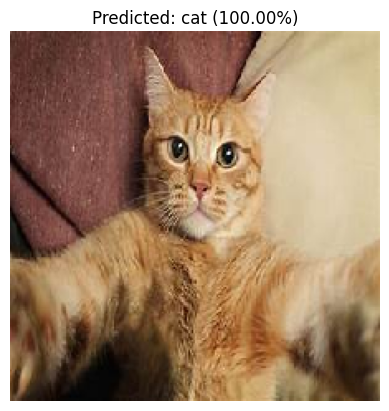

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def test_keras_model(model, class_names):
    # Загрузка и подготовка тестового изображения
    img_path = 'path'  # Укажите путь к вашему изображению
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Получение предсказания
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Визуализация
    plt.imshow(img)
    plt.title(f"Предсказание: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Список классов
class_names = [
    'butterfly', 'cat', 'chicken', 'cow', 'dog',
    'elephant', 'horse', 'monkey', 'sheep', 'squirrel'
] 

# Вызов функции тестирования
test_keras_model(model, class_names)

# Выгрузка названия классов 

In [ ]:
with open('classes.txt', 'w') as f:
    f.write('\n'.join(train_generator.class_indices.keys())) # атрибут генератора данных, который содержит словарь, сопоставляющий названия классов с их индексами